# How do I create my own dataset?


因此Caffe2使用二进制DB格式来存储我们想要训练模型的数据。Caffe2 DB是键值存储的美化名称，其中键通常是随机的，因此批次大约是i.i.d.这些值是真实的东西：它们包含您希望训练算法摄取的特定数据格式的序列化字符串。因此，存储的数据库看起来（语义上）像这样：

key1 value1
key2 value2
key3 value3
...


对于DB，它将键和值视为字符串，但您可能需要结构化内容。一种方法是使用TensorProtos协议缓冲区：它基本上包含张量（也称为多维数组）以及张量数据类型和形状信息。然后，可以使用TensorProtosDBInput运算符将数据加载到SGD训练方式中。


在这里，我们将向您展示如何创建自己的数据集的一个示例。为此，我们将使用UCI Iris数据集 - 这是一个非常流行的经典数据集，用于分类虹膜花。它包含4个代表花朵尺寸的实值特征，并将东西分为3种类型的鸢尾花。数据集可以[这里](https://archive.ics.uci.edu/ml/datasets/Iris)下载。

In [1]:
# First let's import some necessities
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function
from __future__ import unicode_literals

%matplotlib inline
import urllib2 # for downloading the dataset from the web.
import numpy as np
from matplotlib import pyplot
from StringIO import StringIO
from caffe2.python import core, utils, workspace
from caffe2.proto import caffe2_pb2

In [2]:
f = urllib2.urlopen('https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data')
raw_data = f.read()
print('Raw data looks like this:')
print(raw_data[:100] + '...')

Raw data looks like this:
5.1,3.5,1.4,0.2,Iris-setosa
4.9,3.0,1.4,0.2,Iris-setosa
4.7,3.2,1.3,0.2,Iris-setosa
4.6,3.1,1.5,0.2,...


In [3]:
# load the features to a feature matrix.
features = np.loadtxt(StringIO(raw_data), dtype=np.float32, delimiter=',', usecols=(0, 1, 2, 3))
# load the labels to a feature matrix
label_converter = lambda s : {'Iris-setosa':0, 'Iris-versicolor':1, 'Iris-virginica':2}[s]
labels = np.loadtxt(StringIO(raw_data), dtype=np.int, delimiter=',', usecols=(4,), converters={4: label_converter})

在我们进行训练之前，通常有益的一件事是将数据集分成训练和测试。在这种情况下，让我们随机抽取数据，使用前100个数据点进行训练，剩下的50个进行测试。对于更复杂的方法，您可以使用例如交叉验证将您的数据集分成多个训练集和测试集拆分。阅读更多关于交叉验证的信息[这里](http://scikit-learn.org/stable/modules/cross_validation.html)。

In [4]:
random_index = np.random.permutation(150)
features = features[random_index]
labels = labels[random_index]

train_features = features[:100]
train_labels = labels[:100]
test_features = features[100:]
test_labels = labels[100:]

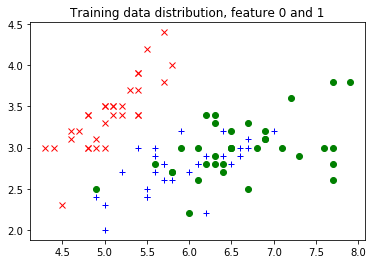

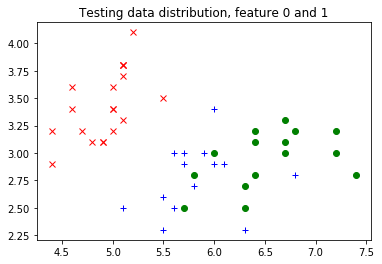

In [5]:
# Let's plot the first two features together with the label.
# Remember, while we are plotting the testing feature distribution
# here too, you might not be supposed to do so in real research,
# because one should not peek into the testing data.
legend = ['rx', 'b+', 'go']
pyplot.title("Training data distribution, feature 0 and 1")
for i in range(3):
    pyplot.plot(train_features[train_labels==i, 0], train_features[train_labels==i, 1], legend[i])
pyplot.figure()
pyplot.title("Testing data distribution, feature 0 and 1")
for i in range(3):
    pyplot.plot(test_features[test_labels==i, 0], test_features[test_labels==i, 1], legend[i])


现在，正如所承诺的那样，让我们把东西放到Caffe2数据库中。在这个DB中，会发生的是我们将使用“train_xxx”作为键，并使用TensorProtos对象为每个数据点存储两个张量：一个作为特征，一个作为标签。我们将使用Caffe2的Python DB接口来实现。

In [8]:
# First, let's see how one can construct a TensorProtos protocol buffer from numpy arrays.
feature_and_label = caffe2_pb2.TensorProtos()
feature_and_label.protos.extend([
    utils.NumpyArrayToCaffe2Tensor(features[0]),
    utils.NumpyArrayToCaffe2Tensor(labels[0])])
print('This is what the tensor proto looks like for a feature and its label:')
print(str(feature_and_label))
print('This is the compact string that gets written into the db:')
#print(feature_and_label.SerializeToString())

This is what the tensor proto looks like for a feature and its label:
protos {
  dims: 4
  data_type: FLOAT
  float_data: 4.80000019073
  float_data: 3.0
  float_data: 1.39999997616
  float_data: 0.10000000149
}
protos {
  data_type: INT32
  int32_data: 0
}

This is the compact string that gets written into the db:


In [9]:
# Now, actually write the db.

def write_db(db_type, db_name, features, labels):
    db = core.C.create_db(db_type, db_name, core.C.Mode.write)
    transaction = db.new_transaction()
    for i in range(features.shape[0]):
        feature_and_label = caffe2_pb2.TensorProtos()
        feature_and_label.protos.extend([
            utils.NumpyArrayToCaffe2Tensor(features[i]),
            utils.NumpyArrayToCaffe2Tensor(labels[i])])
        transaction.put(
            'train_%03d'.format(i),
            feature_and_label.SerializeToString())
    # Close the transaction, and then close the db.
    del transaction
    del db

write_db("minidb", "iris_train.minidb", train_features, train_labels)
write_db("minidb", "iris_test.minidb", test_features, test_labels)


现在，让我们创建一个非常简单的网络，它只包含一个TensorProtosDBInput运算符，以展示我们如何从我们创建的数据库加载数据。对于训练，您可能希望执行更复杂的操作：创建网络，训练网络，获取模型以及运行预测服务。为此，您可以查看MNIST教程以获取详细信息。

In [10]:
net_proto = core.Net("example_reader")
dbreader = net_proto.CreateDB([], "dbreader", db="iris_train.minidb", db_type="minidb")
net_proto.TensorProtosDBInput([dbreader], ["X", "Y"], batch_size=16)

print("The net looks like this:")
print(str(net_proto.Proto()))

The net looks like this:
name: "example_reader"
op {
  output: "dbreader"
  name: ""
  type: "CreateDB"
  arg {
    name: "db_type"
    s: "minidb"
  }
  arg {
    name: "db"
    s: "iris_train.minidb"
  }
}
op {
  input: "dbreader"
  output: "X"
  output: "Y"
  name: ""
  type: "TensorProtosDBInput"
  arg {
    name: "batch_size"
    i: 16
  }
}



In [11]:
workspace.CreateNet(net_proto)

True

In [12]:
# Let's run it to get batches of features.
workspace.RunNet(net_proto.Proto().name)
print("The first batch of feature is:")
print(workspace.FetchBlob("X"))
print("The first batch of label is:")
print(workspace.FetchBlob("Y"))

# Let's run again.
workspace.RunNet(net_proto.Proto().name)
print("The second batch of feature is:")
print(workspace.FetchBlob("X"))
print("The second batch of label is:")
print(workspace.FetchBlob("Y"))

The first batch of feature is:
[[4.8 3.  1.4 0.1]
 [6.5 3.  5.8 2.2]
 [6.7 3.  5.  1.7]
 [6.4 2.8 5.6 2.1]
 [5.4 3.9 1.3 0.4]
 [5.7 4.4 1.5 0.4]
 [5.5 2.4 3.7 1. ]
 [5.4 3.  4.5 1.5]
 [5.  3.3 1.4 0.2]
 [5.1 3.5 1.4 0.3]
 [5.5 2.5 4.  1.3]
 [5.  3.  1.6 0.2]
 [5.  3.5 1.6 0.6]
 [5.2 3.4 1.4 0.2]
 [4.9 3.  1.4 0.2]
 [4.3 3.  1.1 0.1]]
The first batch of label is:
[0 2 1 2 0 0 1 1 0 0 1 0 0 0 0 0]
The second batch of feature is:
[[4.8 3.4 1.6 0.2]
 [6.  2.7 5.1 1.6]
 [6.2 3.4 5.4 2.3]
 [4.7 3.2 1.6 0.2]
 [5.5 2.4 3.8 1.1]
 [6.7 3.1 4.7 1.5]
 [5.7 2.8 4.5 1.3]
 [6.9 3.1 5.1 2.3]
 [6.5 3.  5.2 2. ]
 [6.3 3.3 6.  2.5]
 [5.4 3.7 1.5 0.2]
 [4.8 3.  1.4 0.3]
 [5.9 3.  5.1 1.8]
 [7.3 2.9 6.3 1.8]
 [6.2 2.2 4.5 1.5]
 [7.7 2.6 6.9 2.3]]
The second batch of label is:
[0 1 2 0 1 1 1 2 2 2 0 0 2 2 1 2]
